## 1. Carregamento e Inspeção Inicial dos Dados

Este notebook tem como objetivo desenvolver um modelo de classificação para prever se um tumor é maligno ou benigno usando o dataset Breast Cancer Wisconsin. O primeiro passo é carregar os dados e entender sua estrutura inicial.

In [1]:
# Carregando o dataset e visualizando informações básicas
import pandas as pd
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Observações Iniciais:

*   **569 amostras (pacientes)** e **33 colunas**.
*   **Nenhum valor nulo relevante** nas features principais, o que é ótimo para a qualidade dos dados.
*   **Tipos de Dados:**
    *   `float64`: 31 colunas (features numéricas).
    *   `object`: 1 coluna (`diagnosis`, que é a variável alvo).
    *   `int64`: 1 coluna (`id`, um identificador).
*   Foi identificada uma coluna (`Unnamed: 32`) com 100% de valores nulos, que será removida.

In [2]:
df = df.drop(columns=['id', 'Unnamed: 32'])

A coluna diagnosis originalmente contém textos: 'M' para tumor Maligno e 'B' para tumor Benigno.
O método .map() é utilizado para aplicar um dicionário de mapeamento: 'M' é substituído por 1 e 'B' por 0.

In [3]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

### Separar Features (X) e Target (y)

Para o treinamento do modelo, é fundamental separar os dados em dois conjuntos: as variáveis independentes (features), que são as características usadas para fazer a previsão, e a variável dependente (target), que é o que o modelo tentará prever. Neste caso, `diagnosis` é a variável target, e todas as outras colunas são as features.

In [4]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [7]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Treinamento do Modelo: Regressão Logística (Baseline)

Nesta fase, treinamos nosso primeiro modelo de classificação: a **Regressão Logística**. Este é um algoritmo linear amplamente utilizado para problemas de classificação binária. Ele estima a probabilidade de uma instância pertencer a uma determinada classe.

Configuramos o modelo com alguns parâmetros importantes:

*   `LogisticRegression()`: A classe que implementa o algoritmo de Regressão Logística.
*   `max_iter=5000`: Define o número máximo de iterações para o algoritmo de otimização convergir. Um valor alto garante que o modelo tenha tempo suficiente para aprender, especialmente com datasets maiores ou mais complexos.
*   `class_weight='balanced'`: Este parâmetro é crucial quando as classes na variável alvo (neste caso, maligno e benigno) estão **desbalanceadas**. Ele ajusta automaticamente os pesos para que a classe minoritária receba mais atenção durante o treinamento, evitando que o modelo seja viesado para a classe majoritária e melhorando o desempenho na detecção da classe 'Maligno'.
*   `random_state=42`: Garante a reprodutibilidade dos resultados. Se você rodar o código várias vezes com o mesmo `random_state`, obterá sempre o mesmo resultado.

Após a configuração, o método `.fit(X_train_scaled, y_train)` é utilizado para treinar o modelo, onde `X_train_scaled` são as features de treinamento escaladas e `y_train` é a variável alvo correspondente.

In [8]:
from sklearn.linear_model import LogisticRegression

# modelo baseline
log_reg_bal = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    random_state=42
)
log_reg_bal.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

## 3. Ajuste do Limiar de Decisão (Threshold) e Avaliação Preliminar

Nesta seção, exploramos como o **limiar de decisão** do modelo de Regressão Logística afeta suas métricas de desempenho. Um modelo de classificação binária geralmente prevê uma probabilidade para cada classe. Por padrão, se a probabilidade da classe positiva for maior ou igual a 0.5, o modelo classifica como positivo (1); caso contrário, como negativo (0).

Em contextos como a detecção de câncer, onde falsos negativos (não detectar um tumor maligno) podem ter consequências graves, pode ser desejável **reduzir o limiar de decisão**. Isso significa que o modelo classificará como maligno mesmo com probabilidades um pouco menores, aumentando o Recall (sensibilidade) à custa de, talvez, um pouco mais de falsos positivos.

O código abaixo testa diferentes limiares (0.5, 0.4, 0.35, 0.3) e avalia o modelo com as seguintes métricas:

*   **Recall (Sensibilidade)**: A proporção de tumores malignos reais que foram corretamente identificados como malignos. É crucial em problemas de saúde para minimizar falsos negativos.
*   **F1-score**: A média harmônica entre Precisão e Recall. Uma métrica equilibrada para avaliar o modelo quando ambas as métricas são importantes.
*   **Matriz de Confusão**: Uma tabela que mostra o número de verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN).

In [9]:
y_pred_default = log_reg_bal.predict(X_test_scaled)


In [10]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix


y_proba = log_reg_bal.predict_proba(X_test_scaled)[:, 1]

thresholds = [0.5, 0.4, 0.35, 0.3]

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    print(f"\nThreshold: {t}")
    print("Recall:", recall_score(y_test, y_pred_t))
    print("F1:", f1_score(y_test, y_pred_t))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_t))



Threshold: 0.5
Recall: 0.9523809523809523
F1: 0.963855421686747
Confusion matrix:
 [[71  1]
 [ 2 40]]

Threshold: 0.4
Recall: 0.9523809523809523
F1: 0.963855421686747
Confusion matrix:
 [[71  1]
 [ 2 40]]

Threshold: 0.35
Recall: 0.9523809523809523
F1: 0.963855421686747
Confusion matrix:
 [[71  1]
 [ 2 40]]

Threshold: 0.3
Recall: 0.9523809523809523
F1: 0.9523809523809523
Confusion matrix:
 [[70  2]
 [ 2 40]]


## 5. Avaliação Detalhada do Modelo de Regressão Logística

Após treinar o modelo, é fundamental avaliá-lo com métricas apropriadas para entender seu desempenho. Em problemas de classificação, especialmente em áreas como a saúde, diferentes métricas fornecem perspectivas distintas sobre a qualidade da previsão. Este bloco de código calcula as seguintes métricas no conjunto de testes (`X_test_scaled`, `y_test`):

*   **Accuracy (Acurácia)**: A proporção de previsões corretas (tanto positivos quanto negativos) em relação ao total de previsões. É uma boa métrica geral, mas pode ser enganosa em datasets desbalanceados.

*   **Recall (Sensibilidade) para a classe 'Maligno' (1)**: A proporção de casos malignos reais que foram corretamente identificados como malignos. Em detecção de doenças como o câncer, o Recall é frequentemente uma métrica crítica, pois minimizar falsos negativos (não detectar um tumor maligno) é de extrema importância.

*   **F1-score**: A média harmônica entre Precision (Precisão) e Recall. É útil quando há um balanço entre a importância de ter poucos falsos positivos e poucos falsos negativos. Um F1-score alto indica que o modelo tem boa precisão e bom recall.

*   **ROC-AUC (Area Under the Receiver Operating Characteristic Curve)**: Mede a capacidade do modelo de distinguir entre as classes. Um valor de ROC-AUC próximo de 1 indica um modelo com excelente poder de discriminação, enquanto 0.5 sugere um desempenho aleatório. É robusto a desbalanceamento de classes.

*   **Classification Report (Relatório de Classificação)**: Um relatório abrangente que fornece Precision, Recall, F1-score e Support (número de ocorrências) para cada classe (Benigno e Maligno), além da acurácia geral e médias. É uma excelente forma de ter uma visão completa do desempenho do modelo para cada classe individualmente.

In [11]:
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score,
    classification_report
)

y_pred = log_reg_bal.predict(X_test_scaled)

# probabilidades para ROC-AUC (classe 1 = maligno)
y_proba = log_reg_bal.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall (Maligno=1):", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["Benigno (0)", "Maligno (1)"]))


Accuracy: 0.9736842105263158
Recall (Maligno=1): 0.9523809523809523
F1-score: 0.963855421686747
ROC-AUC: 0.9953703703703703

Classification report:

              precision    recall  f1-score   support

 Benigno (0)       0.97      0.99      0.98        72
 Maligno (1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



### Matriz de Confusão

A **Matriz de Confusão** é uma tabela que permite visualizar o desempenho de um algoritmo de classificação. Cada linha da matriz representa as classes reais (valores verdadeiros) e cada coluna representa as classes previstas pelo modelo. Ela é fundamental para:

*   **Identificar Falsos Positivos (FP)**: Casos em que o modelo previu 'Maligno', mas o tumor era 'Benigno'.
*   **Identificar Falsos Negativos (FN)**: Casos em que o modelo previu 'Benigno', mas o tumor era 'Maligno'.
*   **Verdadeiros Positivos (TP)**: Previsões corretas de 'Maligno'.
*   **Verdadeiros Negativos (TN)**: Previsões corretas de 'Benigno'.

Em contextos médicos, a análise da matriz de confusão é crítica para entender os tipos de erros que o modelo está cometendo e ajustar suas estratégias, se necessário, para minimizar os erros mais custosos (como falsos negativos).

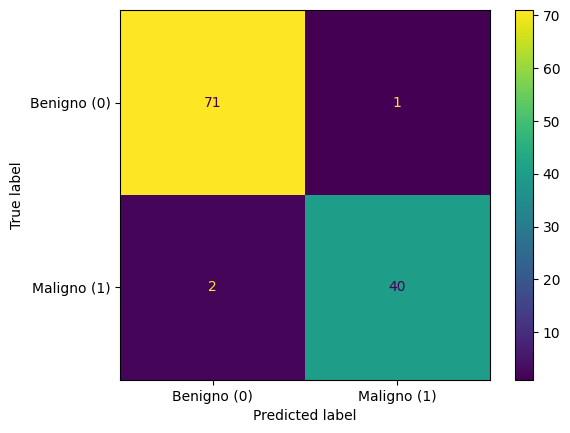

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno (0)", "Maligno (1)"])
disp.plot()
plt.show()


### Curva ROC (Receiver Operating Characteristic)

A **Curva ROC** é um gráfico que ilustra o desempenho de um modelo de classificação binária em diferentes limiares de discriminação. Ela plota a Taxa de Verdadeiros Positivos (TPR, ou Recall) contra a Taxa de Falsos Positivos (FPR) em vários pontos de corte.

*   **Eixo Y (TPR/Recall)**: Indica quantos dos casos positivos foram corretamente identificados.
*   **Eixo X (FPR)**: Indica quantos casos negativos foram incorretamente identificados como positivos.

A **Área sob a Curva ROC (ROC-AUC)**, que é calculada e muitas vezes exibida junto ao gráfico, é uma métrica agregada do desempenho do modelo em todos os possíveis limiares de classificação. Um valor de ROC-AUC mais próximo de 1 indica um modelo com melhor poder discriminatório, ou seja, ele consegue separar melhor as classes positivas das negativas. Uma curva que se inclina rapidamente para o canto superior esquerdo do gráfico é um indicativo de um bom modelo.

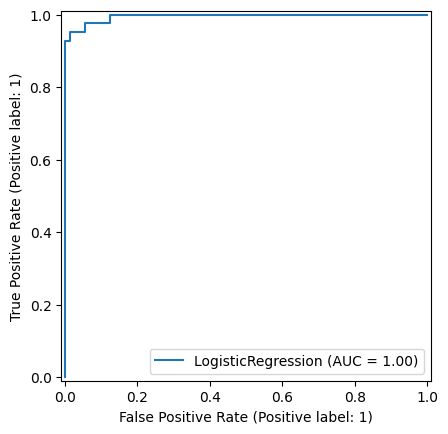

In [13]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(log_reg_bal, X_test_scaled, y_test)
plt.show()

## 6. Interpretação do Modelo: Análise de Importância das Features

A Regressão Logística, por ser um modelo linear, permite uma interpretação direta da importância de cada característica (feature) na sua decisão. Os **coeficientes** do modelo (`log_reg_bal.coef_`) indicam a direção e a magnitude da relação entre cada feature e a probabilidade da classe positiva (Maligno).

*   **Coeficientes Positivos**: Sugerem que um aumento no valor da feature está associado a um aumento na probabilidade de o tumor ser Maligno.
*   **Coeficientes Negativos**: Sugerem que um aumento no valor da feature está associado a uma diminuição na probabilidade de o tumor ser Maligno.
*   **Magnitude dos Coeficientes (valor absoluto)**: Quanto maior o valor absoluto do coeficiente, maior a influência (importância) daquela feature na previsão do modelo.

Este código:
1.  Acessa os coeficientes do modelo treinado (`log_reg_bal.coef_[0]`).
2.  Cria uma `pd.Series` para associar cada coeficiente ao nome da sua respectiva feature.
3.  Ordena essas features pela magnitude absoluta de seus coeficientes (`key=np.abs, ascending=False`), mostrando as 10 features mais importantes no topo. Isso nos ajuda a identificar rapidamente quais características têm o maior impacto nas previsões do modelo.

In [14]:
import numpy as np
import pandas as pd

coef = log_reg_bal.coef_[0]
feat_importance = pd.Series(coef, index=X.columns).sort_values(key=np.abs, ascending=False)

feat_importance.head(10)

,0
texture_worst,1.466159
radius_se,1.309001
symmetry_worst,1.076920
concave points_mean,0.969977
compactness_se,-0.960795
concavity_worst,0.936887
area_se,0.935332
area_worst,0.905379
radius_worst,0.901723
perimeter_se,0.772293


## 7. Treinamento do Modelo: K-Nearest Neighbors (KNN)

Nesta seção, treinamos um segundo modelo de classificação, o **K-Nearest Neighbors (KNN)**. Diferente da Regressão Logística, o KNN é um algoritmo não-paramétrico e baseado em instâncias, o que significa que ele não 'aprende' um modelo em si, mas sim memoriza o conjunto de treinamento e faz previsões baseadas na similaridade com os vizinhos mais próximos.

**Pontos chave deste código:**

1.  **Importação e Instanciação:** Importamos `KNeighborsClassifier` e o instanciamos com `n_neighbors=5`. Este parâmetro define quantos vizinhos mais próximos serão considerados para a decisão de classificação. Embora `k=5` seja um ponto de partida comum, a escolha ideal de `k` pode variar e é frequentemente otimizada via validação cruzada.

2.  **Treinamento (usando dados escalados):** O método `.fit(X_train_scaled, y_train)` treina o modelo. É **crucial usar dados escalados (`X_train_scaled`)** com o KNN, pois este algoritmo calcula distâncias entre os pontos. Se as features tiverem escalas muito diferentes, aquelas com maiores magnitudes dominarão o cálculo da distância, levando a resultados enviesados. O escalonamento garante que todas as features contribuam igualmente.

3.  **Predições:** Após o treinamento, o modelo é usado para fazer:
    *   `y_pred_knn`: Previsões de classe (`0` ou `1`) para o conjunto de teste escalado.
    *   `y_proba_knn`: Probabilidades de pertencimento à classe positiva (Maligno) para o conjunto de teste. Estas probabilidades são importantes para métricas como ROC-AUC e para ajustar o limiar de decisão, se necessário.

In [15]:
# 1. Importar e Instanciar o KNN
from sklearn.neighbors import KNeighborsClassifier

# Vamos começar com k=5 (padrão), mas você pode testar outros valores
knn_model = KNeighborsClassifier(n_neighbors=5)

# 2. Treinar o modelo (usando os dados ESCALADOS, isso é obrigatório pro KNN)
knn_model.fit(X_train_scaled, y_train)

# 3. Fazer predições
y_pred_knn = knn_model.predict(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a curva ROC

## 8. Avaliação Detalhada do Modelo KNN

Após o treinamento do modelo K-Nearest Neighbors (KNN), é fundamental avaliar seu desempenho no conjunto de dados de teste. Esta seção calcula e exibe as principais métricas de avaliação para classficadores binários, permitindo uma comparação justa com o modelo de Regressão Logística:

*   **Accuracy (Acurácia)**: Proporção de previsões corretas. Uma métrica geral, mas que deve ser analisada com cautela em dados desbalanceados.

*   **Recall (Sensibilidade) para a classe 'Maligno' (1)**: Mede a capacidade do modelo de identificar corretamente os casos positivos reais (tumores malignos). É crucial para minimizar falsos negativos em contextos médicos.

*   **F1-score**: A média harmônica entre Precisão e Recall. Oferece um equilíbrio entre as duas, sendo útil quando ambas são importantes.

*   **ROC-AUC (Area Under the Receiver Operating Characteristic Curve)**: Indica a capacidade do modelo de discriminar entre as classes positiva e negativa. Valores mais próximos de 1 denotam um excelente poder discriminatório.

*   **Classification Report (Relatório de Classificação)**: Um resumo completo das métricas Precision, Recall, F1-score e Support para cada classe, fornecendo uma visão granular do desempenho do modelo.

Além disso, é apresentada a **Matriz de Confusão** do modelo KNN, que visualiza os Verdadeiros Positivos (TP), Verdadeiros Negativos (TN), Falsos Positivos (FP) e Falsos Negativos (FN), ajudando a identificar os tipos de erros que o modelo está cometendo.

--- Avaliação do Modelo KNN ---
Accuracy: 0.956140350877193
Recall (Maligno): 0.9047619047619048
F1-score: 0.9382716049382716
ROC-AUC: 0.982308201058201

Classification Report KNN:

              precision    recall  f1-score   support

 Benigno (0)       0.95      0.99      0.97        72
 Maligno (1)       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



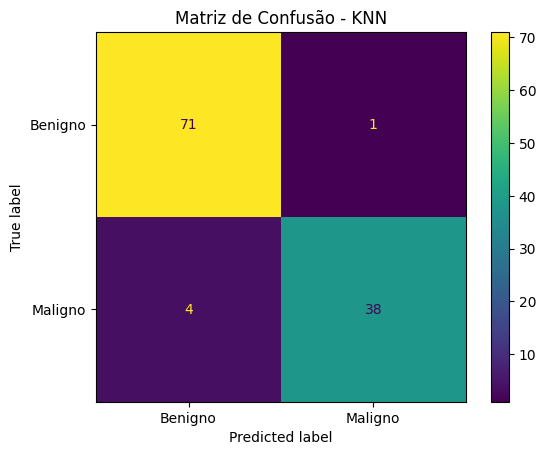

In [16]:
print("--- Avaliação do Modelo KNN ---")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Recall (Maligno):", recall_score(y_test, y_pred_knn))
print("F1-score:", f1_score(y_test, y_pred_knn))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_knn))

print("\nClassification Report KNN:\n")
print(classification_report(y_test, y_pred_knn, target_names=["Benigno (0)", "Maligno (1)"]))

# Matriz de Confusão do KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Benigno", "Maligno"])
disp_knn.plot()
plt.title("Matriz de Confusão - KNN")
plt.show()

## 9. Comparativo de Desempenho entre Modelos

Após avaliar individualmente a Regressão Logística e o KNN, é fundamental ter uma visão consolidada do desempenho de ambos para decidir qual deles é mais adequado para a tarefa. Este bloco de código cria uma tabela comparativa com as principais métricas de avaliação.

*   **Criação do dicionário `resultados`**: Um dicionário é populado com as métricas calculadas anteriormente (Acurácia, Recall, F1-Score e ROC-AUC) para cada modelo.
*   **Conversão para DataFrame**: O dicionário é então convertido em um DataFrame do pandas (`df_resultados`), proporcionando uma visualização estruturada e fácil de ler dos resultados.

Esta tabela permite uma comparação direta e objetiva, ajudando a identificar qual modelo apresenta o melhor balanço entre as métricas consideradas mais importantes para o problema de classificação de câncer de mama.

In [17]:
# Criando um comparativo
resultados = {
    'Modelo': ['Regressão Logística', 'KNN'],
    'Acurácia': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_knn)],
    'Recall (Sensibilidade)': [recall_score(y_test, y_pred), recall_score(y_test, y_pred_knn)],
    'F1-Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_knn)],
    'ROC-AUC': [roc_auc_score(y_test, y_proba), roc_auc_score(y_test, y_proba_knn)]
}

df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Acurácia,Recall (Sensibilidade),F1-Score,ROC-AUC
0,Regressão Logística,0.973684,0.952381,0.963855,0.995370
1,KNN,0.956140,0.904762,0.938272,0.982308


### Comparação das Curvas ROC

Para complementar a análise numérica, a **comparação visual das Curvas ROC** dos modelos de Regressão Logística e KNN oferece uma perspectiva clara sobre o desempenho relativo de cada um. Este gráfico:

*   **Plota a Curva ROC para cada modelo**: Cada linha representa a capacidade de um modelo de separar as classes positiva e negativa em diversos limiares de decisão.
*   **Exibe o ROC-AUC de cada modelo**: A Área Sob a Curva (AUC) é um valor numérico que sumariza o desempenho de um modelo em todos os limiares. Quanto mais próxima de 1, melhor o poder discriminatório do modelo.
*   **Inclui uma linha de base 'Aleatório'**: A linha pontilhada (`k--`) representa um classificador aleatório (AUC = 0.5), servindo como referência. Qualquer modelo real deve ter um desempenho superior a esta linha.

Ao visualizar as curvas, podemos identificar rapidamente qual modelo consegue atingir uma maior Taxa de Verdadeiros Positivos (Recall) com uma menor Taxa de Falsos Positivos, indicando um modelo mais robusto e eficaz. Um modelo com uma curva mais próxima do canto superior esquerdo do gráfico é geralmente o preferido.

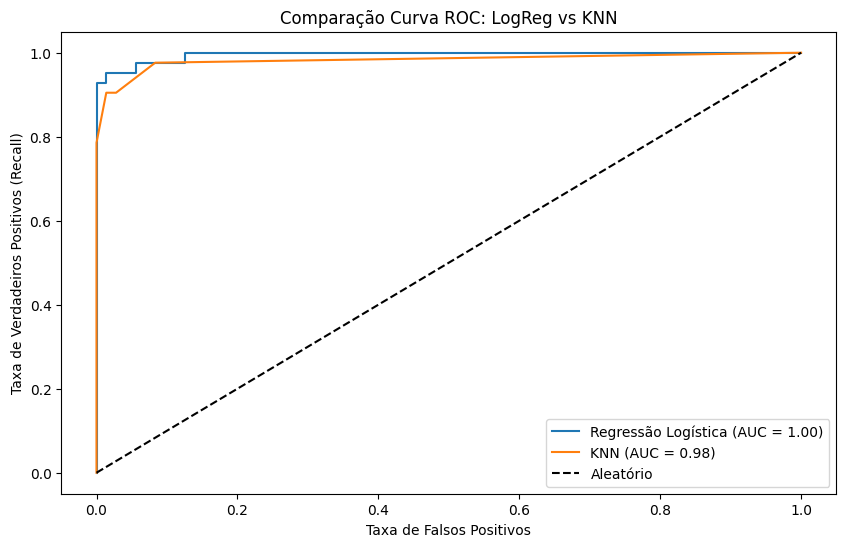

In [18]:
from sklearn.metrics import roc_curve

# Calculando as curvas
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)

# Plotando
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Regressão Logística (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_score(y_test, y_proba_knn):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Comparação Curva ROC: LogReg vs KNN')
plt.legend()
plt.show()

## 10. Interpretabilidade do Modelo com SHAP (SHapley Additive exPlanations)

Nesta seção, introduzimos a biblioteca **SHAP**, uma ferramenta poderosa para explicar as previsões de qualquer modelo de machine learning. O SHAP atribui a importância de cada feature para uma previsão individual, mostrando como cada característica contribui para o resultado final do modelo.

Este bloco de código realiza duas ações principais:

1.  **Instalação da biblioteca SHAP**: A linha `!pip install shap` garante que a biblioteca SHAP esteja instalada no ambiente do Colab/Jupyter, pois ela não vem pré-instalada por padrão.
2.  **Inicialização para visualizações interativas**: `shap.initjs()` é chamado para inicializar o JavaScript necessário para as visualizações interativas que o SHAP oferece. Isso permite que você visualize graficamente a contribuição de cada feature de forma dinâmica e compreensível.

In [19]:
# Instalando a biblioteca SHAP (necessário no Colab/Jupyter)
!pip install shap

import shap
# Inicializa o JavaScript para visualizações interativas
shap.initjs()

### Configuração do SHAP Explainer e Cálculo de SHAP Values

Nesta fase, configuramos a ferramenta SHAP para começar a interpretar as previsões do modelo de Regressão Logística. Os `SHAP values` quantificam o impacto de cada feature em uma previsão individual, explicando por que o modelo fez uma determinada decisão.

1.  **Recuperação dos Nomes das Colunas (`feature_names = X.columns`)**:
    *   É importante ter os nomes originais das features para que as visualizações SHAP sejam compreensíveis e relacionem os valores SHAP às características corretas.

2.  **Criação do Explainer (`explainer = shap.LinearExplainer(...)`)**:
    *   `shap.LinearExplainer` é o tipo de explainer recomendado para modelos lineares, como a Regressão Logística.
    *   Ele recebe o modelo treinado (`log_reg_bal`) e um conjunto de dados de referência (`X_train_scaled`). Este `X_train_scaled` atua como o 'background dataset' ou 'baseline' para a computação dos SHAP values, representando o comportamento médio das features.
    *   `feature_perturbation="interventional"` especifica como as features são perturbadas para calcular seus impactos. Para modelos lineares, esta é uma configuração comum.

3.  **Cálculo dos SHAP Values (`shap_values = explainer.shap_values(X_test_scaled)`)**:
    *   Este passo aplica o `explainer` aos dados de teste escalados (`X_test_scaled`) para gerar os SHAP values para cada previsão no conjunto de teste.
    *   Para problemas de classificação binária, o `shap_values` pode retornar uma lista onde cada elemento corresponde a uma classe. A linha `if isinstance(shap_values, list): shap_values = shap_values[1]` garante que estamos pegando os SHAP values para a classe positiva (Maligno), que geralmente é o foco da análise.

In [20]:
# 1. Recuperar nomes das colunas
feature_names = X.columns

# 2. Criar o Explainer com o modelo de Regressão Logística
# Passamos o modelo e os dados de treino (como "background" para comparação)
explainer = shap.LinearExplainer(log_reg_bal, X_train_scaled, feature_perturbation="interventional")

# 3. Calcular os SHAP values para os dados de teste
shap_values = explainer.shap_values(X_test_scaled)

# Verificação (opcional): O shap_values para classificação binária pode retornar uma lista.
# Se for lista, pegamos o índice 1 (classe positiva/maligno)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


### Visualização da Interpretabilidade: SHAP Summary Plot

O **SHAP Summary Plot** é uma das visualizações mais informativas da biblioteca SHAP, fornecendo uma visão agregada da importância e do impacto direcional de cada feature nas previsões do modelo. Ele combina a importância global das features com a sua direção de efeito para cada instância.

**Como interpretar o Summary Plot:**

*   **Eixo Y**: Lista as features em ordem decrescente de importância (as mais importantes no topo).
*   **Eixo X**: Representa o valor SHAP para aquela feature. Um valor SHAP positivo significa que a feature aumentou a probabilidade de a classe ser 'Maligno' (1), enquanto um valor negativo diminuiu essa probabilidade.
*   **Cor dos Pontos**: A cor de cada ponto indica o valor da feature para aquela instância específica. Geralmente, `vermelho` indica um valor alto da feature e `azul` indica um valor baixo da feature.
*   **Dispersão dos Pontos**: A dispersão horizontal dos pontos para cada feature mostra a variedade do impacto dessa feature entre as diferentes instâncias do conjunto de dados. Pontos sobrepostos são "jittered" (ligeiramente deslocados horizontalmente) para melhor visualização.

Este gráfico permite identificar rapidamente:
*   Quais features têm o maior impacto (positiva ou negativamente) na previsão de um tumor maligno.
*   Como diferentes valores de uma feature específica influenciam essa previsão (por exemplo, valores altos de 'radius_worst' tendem a aumentar a probabilidade de malignidade, enquanto valores baixos tendem a diminuir).

Interpretando o impacto das features na probabilidade de Câncer Maligno:


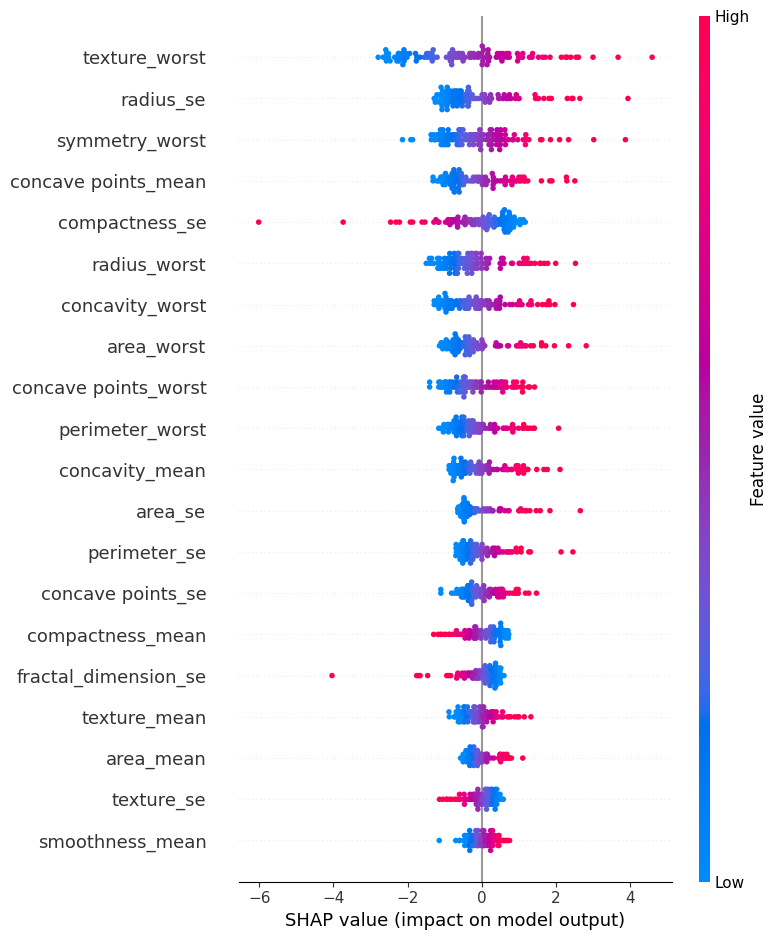

In [21]:
# Plotando o Summary Plot
# transformamos X_test_scaled em DataFrame apenas para o gráfico ter os nomes certos
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print("Interpretando o impacto das features na probabilidade de Câncer Maligno:")
shap.summary_plot(shap_values, X_test_df)

## 11. Conclusão e Discussão Crítica dos Resultados

### Comparativo de Desempenho dos Modelos

Após o treinamento e avaliação, a **Regressão Logística** demonstrou um desempenho ligeiramente superior em comparação com o modelo K-Nearest Neighbors (KNN) para este dataset:

*   **Regressão Logística (Logistic Regression):**
    *   Acurácia: 0.9737
    *   Recall (Sensibilidade): 0.9524
    *   F1-Score: 0.9639
    *   ROC-AUC: 0.9954

*   **KNN (K-Nearest Neighbors):**
    *   Acurácia: 0.9561
    *   Recall (Sensibilidade): 0.9048
    *   F1-Score: 0.9383
    *   ROC-AUC: 0.9823

Apesar de ambos os modelos apresentarem métricas excelentes, a Regressão Logística se destacou principalmente no **Recall** para a classe Maligno, que é uma métrica crítica em diagnósticos médicos, pois minimiza a ocorrência de falsos negativos (não identificar um tumor maligno). A Curva ROC também confirmou a superioridade da Regressão Logística em separar as classes, com um ROC-AUC mais próximo de 1.

### Interpretabilidade e Importância das Features

A análise dos **coeficientes da Regressão Logística** e o **SHAP Summary Plot** foram fundamentais para entender o "raciocínio" do modelo. As features mais influentes na previsão de um tumor maligno incluíram `texture_worst`, `radius_se`, `symmetry_worst` e `concave points_mean`. Observamos, por exemplo, que valores mais altos de `texture_worst` e `radius_se` tendem a aumentar significativamente a probabilidade de um diagnóstico de malignidade, enquanto `compactness_se` (com coeficiente negativo) tende a diminuir.

Essa interpretabilidade é crucial, especialmente em aplicações médicas, pois permite:

*   **Validação por Especialistas:** Médicos podem revisar e validar se as características que o modelo considera importantes fazem sentido clínico.
*   **Construção de Confiança:** Entender *por que* o modelo faz uma previsão ajuda a construir confiança no sistema, um pré-requisito para sua adoção.
*   **Identificação de Novos Insights:** Pode-se descobrir características que, mesmo que já conhecidas, o modelo reforça como de alta relevância.

### Discussão Crítica e Aplicabilidade Prática

Os resultados obtidos são muito promissores, indicando que a Regressão Logística, com um Recall de 95% e um ROC-AUC de 99.5%, é um modelo robusto para a previsão de câncer de mama neste dataset. No entanto, é crucial abordar a aplicabilidade prática com responsabilidade:

1.  **Ferramenta de Suporte, Não de Substituição:** O modelo deve ser visto como uma **ferramenta de apoio à decisão**, e não como um substituto para o julgamento clínico de um médico. Em hipótese alguma a decisão final de um diagnóstico deve ser baseada exclusivamente na saída de um algoritmo.

2.  **Onde Pode Ser Utilizado:**
    *   **Triagem e Priorização:** Em cenários de alta demanda, o modelo poderia ajudar a priorizar casos que têm maior probabilidade de malignidade, direcionando-os para avaliação médica mais rápida.
    *   **Segunda Opinião:** Pode ser usado como uma "segunda opinião" automatizada para auxiliar médicos menos experientes ou para confirmar diagnósticos em casos complexos.
    *   **Redução de Carga de Trabalho:** Em exames de rotina, o modelo poderia sinalizar anomalias, reduzindo o tempo de análise manual e permitindo que os médicos se concentrem em casos mais críticos.

3.  **A Importância do Falso Negativo:** No contexto de saúde, um falso negativo (classificar um tumor maligno como benigno) pode ter consequências catastróficas. Por isso, a alta sensibilidade (Recall) da Regressão Logística é um ponto forte. Se necessário, o limiar de decisão poderia ser ajustado para otimizar ainda mais o Recall, mesmo que à custa de um pequeno aumento nos falsos positivos, garantindo que o máximo de casos malignos sejam detectados.

4.  **Necessidade de Validação Clínica:** Antes de qualquer implementação prática, o modelo exigiria uma **validação clínica rigorosa** com dados reais, prospectivos e de diversas fontes, além de aprovação regulatória. A performance em um conjunto de teste pode não se traduzir perfeitamente para a prática clínica real.

Em resumo, o modelo desenvolvido demonstra um grande potencial como um recurso valioso para auxiliar médicos no diagnóstico de câncer de mama, mas sempre sob supervisão humana e após validação exaustiva em um ambiente clínico controlado.